In [41]:
pip install Topsis-Naman-102116058

In [42]:
pip install sentence_transformers

In [43]:
from sentence_transformers import SentenceTransformer, util
import torch
import csv

def calculate_distances(query_embedding, passage_embeddings):
    cosine_similarity_scores = util.pytorch_cos_sim(query_embedding, passage_embeddings)
    euclidean_distances = torch.cdist(query_embedding.unsqueeze(0), passage_embeddings.unsqueeze(0), p=2)
    manhattan_distances = torch.cdist(query_embedding.unsqueeze(0), passage_embeddings.unsqueeze(0), p=1)
    minkowski_distances = torch.cdist(query_embedding.unsqueeze(0), passage_embeddings.unsqueeze(0), p=3)
    return cosine_similarity_scores, euclidean_distances, manhattan_distances, minkowski_distances

def normalize_and_save_results(model, model_name, query, passages, results):
    query_embedding = model.encode(query, convert_to_tensor=True)
    passage_embeddings = model.encode(passages, convert_to_tensor=True)

    query_embedding /= query_embedding.norm(dim=-1, keepdim=True)
    passage_embeddings /= passage_embeddings.norm(dim=-1, keepdim=True)

    cosine_similarity_scores, euclidean_distances, manhattan_distances, minkowski_distances = calculate_distances(query_embedding, passage_embeddings)

    model_results = {
        "Model": model_name,
        "Cosine Similarity": max(cosine_similarity_scores[0].tolist()),
        "Euclidean Distance": euclidean_distances.min().item(),
        "Manhattan Distance": manhattan_distances.min().item(),
        "Minkowski Distance": minkowski_distances.min().item(),
    }

    results.append(model_results)

def scale_distances_and_save_csv(results):
    min_euclidean_distance = min(result["Euclidean Distance"] for result in results)
    max_euclidean_distance = max(result["Euclidean Distance"] for result in results)

    min_manhattan_distance = min(result["Manhattan Distance"] for result in results)
    max_manhattan_distance = max(result["Manhattan Distance"] for result in results)

    min_minkowski_distance = min(result["Minkowski Distance"] for result in results)
    max_minkowski_distance = max(result["Minkowski Distance"] for result in results)

    for result in results:
        result["Scaled Euclidean Distance"] = (result["Euclidean Distance"] - min_euclidean_distance) / (max_euclidean_distance - min_euclidean_distance)
        result["Scaled Manhattan Distance"] = (result["Manhattan Distance"] - min_manhattan_distance) / (max_manhattan_distance - min_manhattan_distance)
        result["Scaled Minkowski Distance"] = (result["Minkowski Distance"] - min_minkowski_distance) / (max_minkowski_distance - min_minkowski_distance)

    fieldnames = ['Model', 'Cosine Similarity', 'Euclidean Distance', 'Manhattan Distance', 'Minkowski Distance', 'Scaled Euclidean Distance', 'Scaled Manhattan Distance', 'Scaled Minkowski Distance']
    csv_file_path = 'distance_results.csv'

    with open(csv_file_path, 'w', newline='') as csv_file:
        csv_writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
        csv_writer.writeheader()
        csv_writer.writerows(results)

    print(f"Similarity scores have been saved to {csv_file_path}")

if __name__ == "__main__":
    models = [
        SentenceTransformer("paraphrase-distilroberta-base-v1"),
        SentenceTransformer("stsb-mpnet-base-v2"),
        SentenceTransformer("quora-distilbert-base"),
        SentenceTransformer("paraphrase-MiniLM-L12-v2"),
        SentenceTransformer("msmarco-distilbert-base-v3")
    ]

    query = 'A cat is sleeping on the windowsill'
    passages = ['The lazy dog is lying on the couch', 'A cute kitten is napping in the sun', 'Birds are chirping outside the house']

    results = []

    for i, model in enumerate(models, start=1):
        model_name = f"M{i}"
        normalize_and_save_results(model, model_name, query, passages, results)

    scale_distances_and_save_csv(results)


Similarity scores have been saved to distance_results.csv


In [44]:
from Topsis_Naman_102116058.topsis import topsis
inputFile="distance_results.csv"
weights="1,1,1,1,1,1,1"
impacts="+,-,-,-,-,-,-"
resultFile="result_topsis.csv"
topsis(inputFile, weights, impacts, resultFile)

  Model  Cosine Similarity  Euclidean Distance  Manhattan Distance  \
0    M1           0.602293            0.891859           19.253952   
1    M2           0.625652            0.865272           18.560080   
2    M3           0.663817            0.819980           17.598669   
3    M4           0.506906            0.993070           15.315597   
4    M5           0.470986            1.028605           22.886974   

   Minkowski Distance  Scaled Euclidean Distance  Scaled Manhattan Distance  \
0            0.350494                   0.344539                   0.520164   
1            0.349404                   0.217099                   0.428519   
2            0.326562                   0.000000                   0.301540   
3            0.432072                   0.829672                   0.000000   
4            0.393147                   1.000000                   1.000000   

   Scaled Minkowski Distance  
0                   0.226823  
1                   0.216488  
2          

<ipython-input-45-784ec7ac487f>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=topsis_scores, y=models, palette="viridis", orient='h')


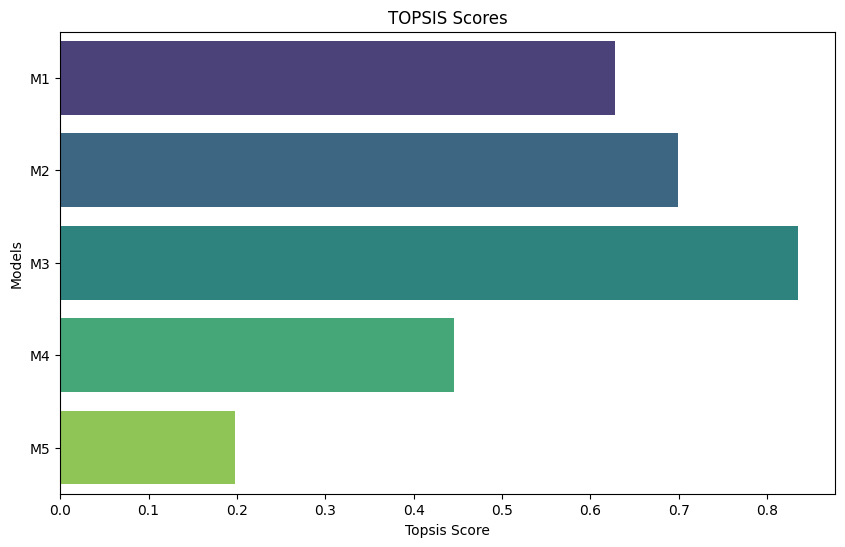

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
result_file = "result_topsis.csv"
topsis_results = pd.read_csv(result_file)

# Extracting the performance scores and alternatives
topsis_scores = topsis_results['Topsis Score']
models = topsis_results['Model']

# Create a bar plot to visualize the performance scores
plt.figure(figsize=(10, 6))
sns.barplot(x=topsis_scores, y=models, palette="viridis", orient='h')
plt.title("TOPSIS Scores")
plt.xlabel("Topsis Score")
plt.ylabel("Models")
plt.show()